In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""Train forecasting model.

Author:
    Erik Johannes Husom

Created:
    2024-03-21

"""
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from config import config

2024-06-04 17:42:40.433128: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 17:42:41.098117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Function to preprocess the data
def preprocess_data(df, target_column, scale_features=False, unique_val_threshold=7):

    # Drop unrelated or irrelevant variables
    columns_to_drop = [
            "energy_consumption_monitoring",
            # "total_duration",
            # "response_duration",
            #"response_token_length",
            "prompt_duration",
            "index",
            "load_duration",
            "Unnamed: 0",
            "created_at",
            "response",
            # "prompt",
            # "text_standard",
    ]
    df = df.drop(columns=columns_to_drop)

    # df = df[[target_column, "prompt", "type"]]

    # Drop target column and rows with NA in target column
    df = df.dropna(subset=[target_column])
    y = df[target_column]
    X = df.drop(columns=[target_column])
    X = X[[
        'prompt', 
        'type',
        "model_name",
        # "total_duration",
        # "load_duration",
        "prompt_token_length",
        # "prompt_duration",
        # "response_token_length",
        # "response_duration",
        # "response",
        # "energy_consumption_monitoring",
        # "energy_consumption_llm",
        "word_count",
        "sentence_count",
        "avg_word_length",
        "word_diversity",
        "unique_word_count",
        "avg_sentence_length",
        "punctuation_count",
        "stop_word_count",
        "long_word_count",
        "named_entity_count",
        "noun_count",
        "verb_count",
        "adj_count",
        "adverb_count",
        "pronoun_count",
        "prop_adverbs",
        "prop_pronouns",
        "sentiment_polarity",
        "sentiment_subjectivity",
        "flesch_reading_ease",
        "flesch_kincaid_grade",
        "gunning_fog",
        "smog_index",
        "automated_readability_index",
        "coleman_liau_index",
        "linsear_write_formula",
        "dale_chall_readability_score",
        # "text_standard",
        "spache_readability",
        "mcalpine_eflaw",
        "reading_time",
        "fernandez_huerta",
        "szigriszt_pazos",
        "gutierrez_polini",
        "crawford",
        "osman",
        "gulpease_index",
        "wiener_sachtextformel",
        "syllable_count",
        "lexicon_count",
        "char_count",
        "letter_count",
        "polysyllabcount",
        "monosyllabcount",
        "question_marks",
        "exclamation_marks",
        "sentence_embedding_variance",
        "personal_pronouns",
        "named_entities",
        "adjectives",
        "adverbs",
        "length_x_complexity",
        "questions_about_entities",
        "desc_complexity_ratio",
        "word_count_squared",
        "avg_sentence_length_cubed",
        "lexical_diversity",
    ]]

    # Identify numeric, text, and categorical columns
    numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    potential_categorical = X.select_dtypes(include=['object', 'category']).columns.tolist()
    text_columns = [col for col in potential_categorical if X[col].nunique() > unique_val_threshold]
    categorical_columns = list(set(potential_categorical) - set(text_columns))

    # X = X.drop(columns=text_columns)

    # Define transformers
    transformers = []
    if scale_features:
        transformers.append(('num', StandardScaler(), numeric_columns))
    if text_columns:
        transformers.append(('text', TfidfVectorizer(), "prompt"))
    if categorical_columns:
        transformers.append(('cat', OneHotEncoder(), categorical_columns))

    # Column Transformer
    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Applying the ColumnTransformer
    # Note: This step now includes fitting the transformer, so it should be applied here rather than in the model pipeline.
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, X_test, y_train, y_test

def neural_network(input_shape=57):
    model = Sequential([
        Dense(16, activation='relu', input_shape=(input_shape,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(), loss='mse')

    return model

# Function to select the machine learning model
def select_model(model_name):
    models = {
        "random_forest": RandomForestRegressor(),
        "decision_tree": DecisionTreeRegressor(),
        "gradient_boosting": GradientBoostingRegressor(),
        "xgboost": xgb.XGBRegressor(),
        "svm": SVR(),
        "linear_regression": LinearRegression(),
        "neural_network": neural_network(),
    }
    return models.get(model_name, LinearRegression())  # Default to Linear Regression

# Function to train the model and evaluate it
def train_and_evaluate(file_name, model_name, X_train, X_test, y_train, y_test):
    model = select_model(model_name)

    if model_name == "neural_network":
        model.fit(X_train, y_train, epochs=1000)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # print(f"Model: {model_name}")
    # print(f"MSE: {mse}")
    # print(f"MAE: {mae}")
    # print(f"R^2: {r2}")
    print(f"{file_name[:file_name.index('.csv')]} & {mse} & {mae} & {r2}")

    # if r2 > 0.2:
    plot_true_vs_predicted(y_test, y_pred, model_name, file_name)

    return model, mse, mae, r2

def plot_true_vs_predicted(y_true, y_pred, model_name, file_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predicted')
    plt.plot(y_true, y_true, color='red', label='True')  # Line for perfect predictions
    plt.title(f'True vs. Predicted Energy Consumption - {file_name}_{model_name}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{config.PLOTS_DIR_PATH}/{file_name}_{model_name}_onlyprompt.pdf")
    plt.show()

def new_train(df):
    # Preparing the dataset
    X = df[[
        'prompt', 
        'type',
        # "model_name",
        # "total_duration",
        # "load_duration",
        "prompt_token_length",
        # "prompt_duration",
        # "response_token_length",
        # "response_duration",
        # "response",
        # "energy_consumption_monitoring",
        # "energy_consumption_llm",
        "word_count",
        "sentence_count",
        "avg_word_length",
        "word_diversity",
        "unique_word_count",
        "avg_sentence_length",
        "punctuation_count",
        "stop_word_count",
        "long_word_count",
        "named_entity_count",
        "noun_count",
        "verb_count",
        "adj_count",
        "adverb_count",
        "pronoun_count",
        "prop_adverbs",
        "prop_pronouns",
        "sentiment_polarity",
        "sentiment_subjectivity",
        "flesch_reading_ease",
        "flesch_kincaid_grade",
        "gunning_fog",
        "smog_index",
        "automated_readability_index",
        "coleman_liau_index",
        "linsear_write_formula",
        "dale_chall_readability_score",
        "text_standard",
        "spache_readability",
        "mcalpine_eflaw",
        "reading_time",
        "fernandez_huerta",
        "szigriszt_pazos",
        "gutierrez_polini",
        "crawford",
        "osman",
        "gulpease_index",
        "wiener_sachtextformel",
        "syllable_count",
        "lexicon_count",
        "char_count",
        "letter_count",
        "polysyllabcount",
        "monosyllabcount",
        "question_marks",
        "exclamation_marks",
        "sentence_embedding_variance",
        "personal_pronouns",
        "named_entities",
        "adjectives",
        "adverbs",
        "length_x_complexity",
        "questions_about_entities",
        "desc_complexity_ratio",
        "word_count_squared",
        "avg_sentence_length_cubed",
        "lexical_diversity",
    ]]
    y = df['energy_consumption_llm']

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Defining the transformation for text and categorical columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('text', TfidfVectorizer(), 'prompt'),
            ('cat', OneHotEncoder(), ['type'])
        ])

    # Creating a modeling pipeline
    model = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100))
    # model = make_pipeline(preprocessor, LinearRegression())

    # Training the model
    model.fit(X_train, y_train)

    print(X_train)
    print(y_train)

    # Predicting and evaluating
    y_pred = model.predict(X_test)
    print("RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
    print("R2: ", r2_score(y_test, y_pred))

    plot_true_vs_predicted(y_test, y_pred, "RandomForestRegressor")



alpaca_llama3_70b_gpu.csv
../data/main_results/alpaca_llama3_70b_gpu.csv


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: random_forest
MSE: 2.2729075473273747e-06
MAE: 0.0011336515629435915
R^2: 0.3541239898078836


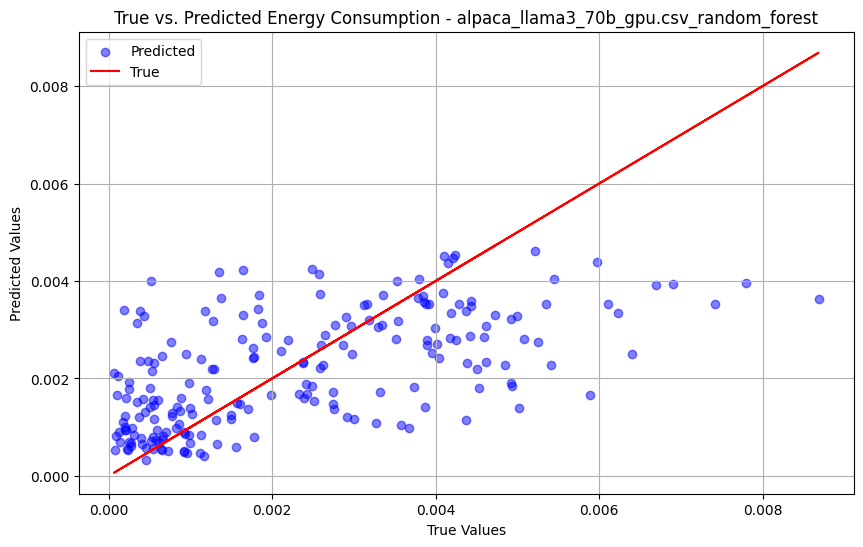

Model: decision_tree
MSE: 4.526924788926615e-06
MAE: 0.001559415999466719
R^2: -0.2863840962426005


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


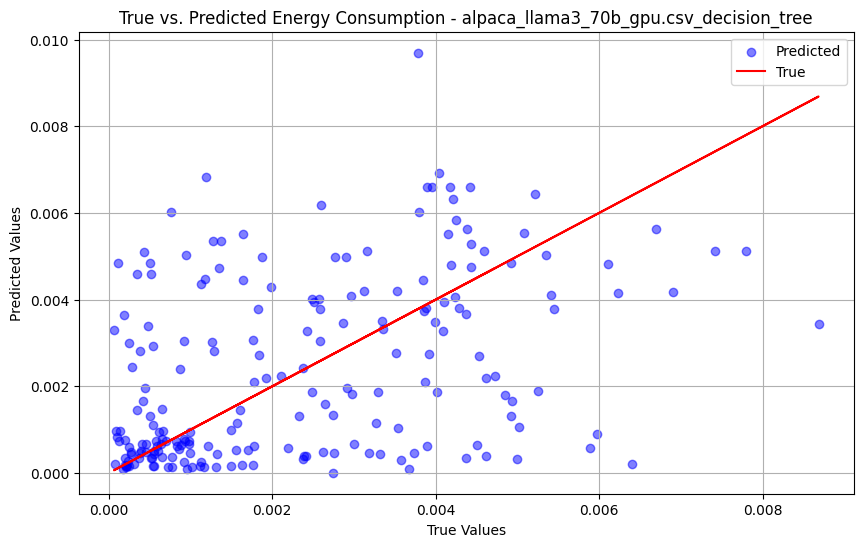

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: xgboost
MSE: 1.934325494773358e-06
MAE: 0.001087298683985282
R^2: 0.4503364492558649


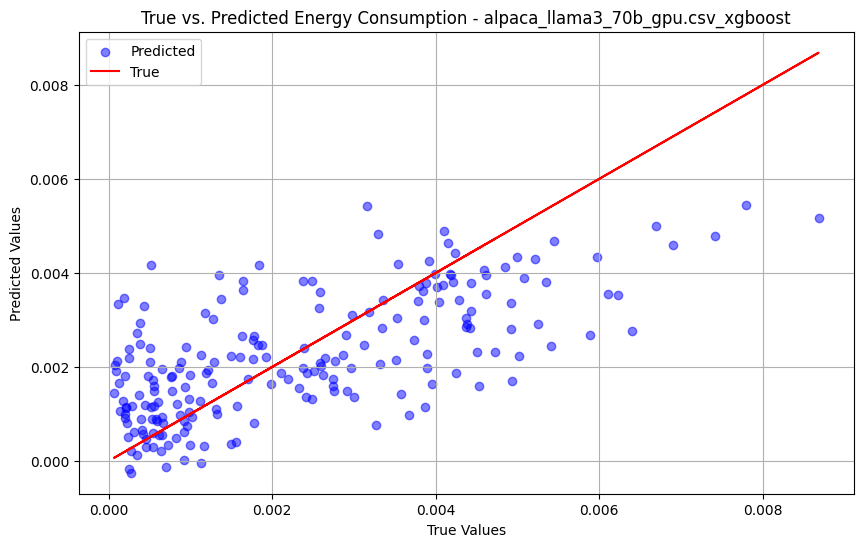

alpaca_gemma_7b_zbook.csv
../data/main_results/alpaca_gemma_7b_zbook.csv


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: random_forest
MSE: 3.874444102095582e-09
MAE: 4.4542145768820166e-05
R^2: 0.45963451322136284


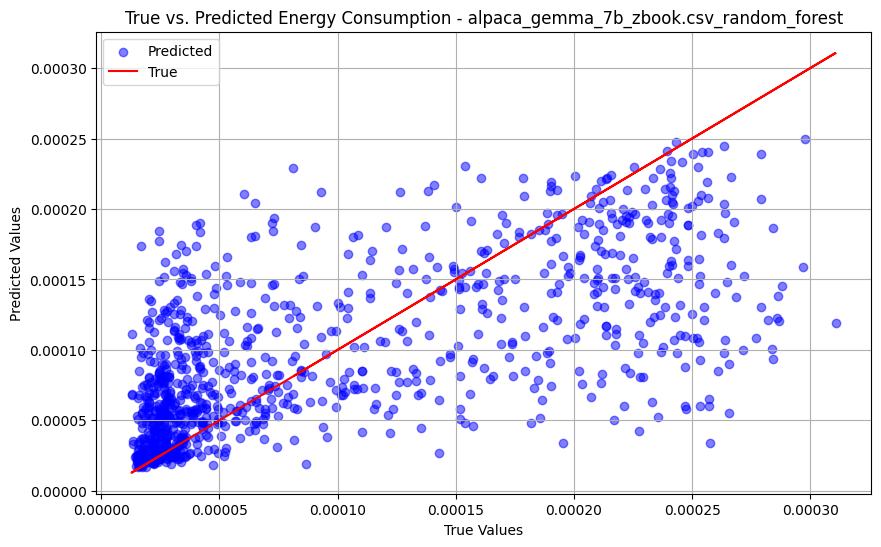

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: decision_tree
MSE: 7.1362067231461066e-09
MAE: 5.557457505808309e-05
R^2: 0.004719201492638159


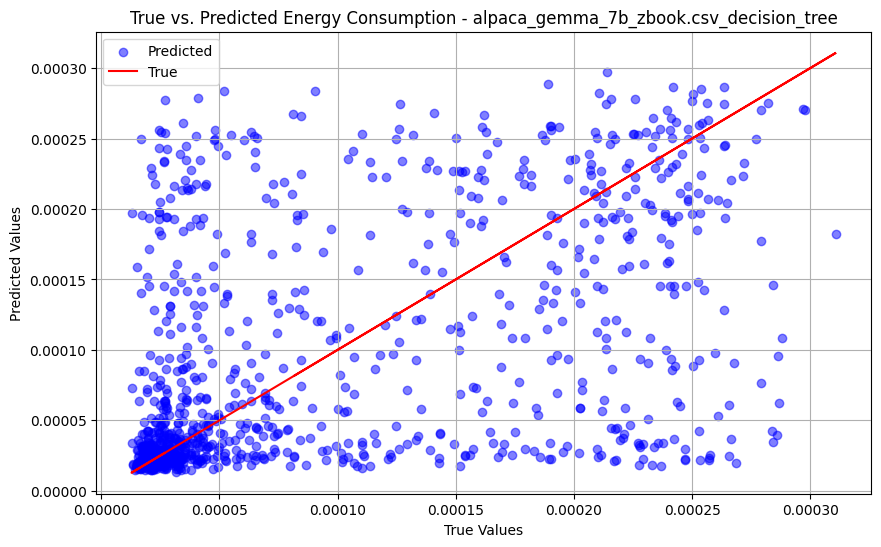

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: xgboost
MSE: 6.208099174813106e-09
MAE: 6.918510664798785e-05
R^2: 0.13416158701231373


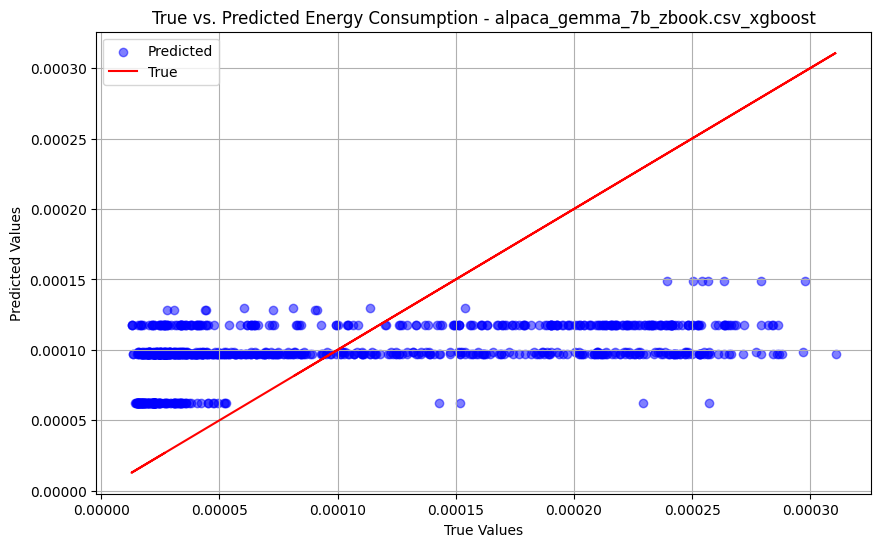

alpaca_gemma_7b_ws.csv
../data/main_results/alpaca_gemma_7b_ws.csv


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: random_forest
MSE: 4.063196873261032e-09
MAE: 4.638386628214051e-05
R^2: 0.5077676328024164


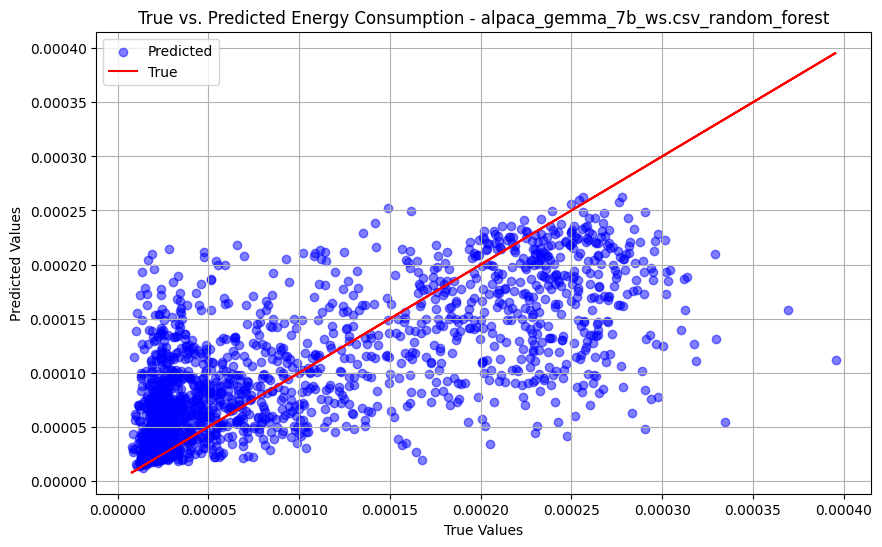

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: decision_tree
MSE: 8.108675909988756e-09
MAE: 5.9668628098034567e-05
R^2: 0.017681677135074736


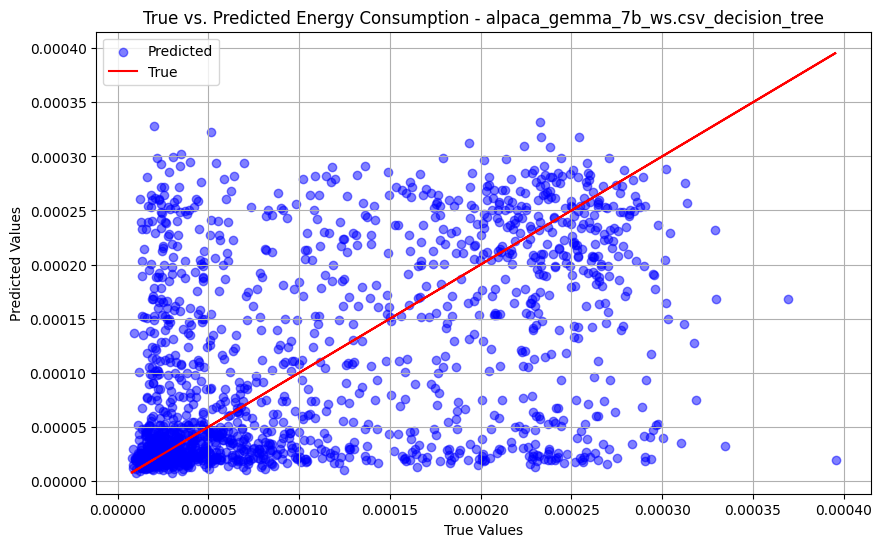

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: xgboost
MSE: 6.365684467109713e-09
MAE: 6.833709954500723e-05
R^2: 0.22883482346167783


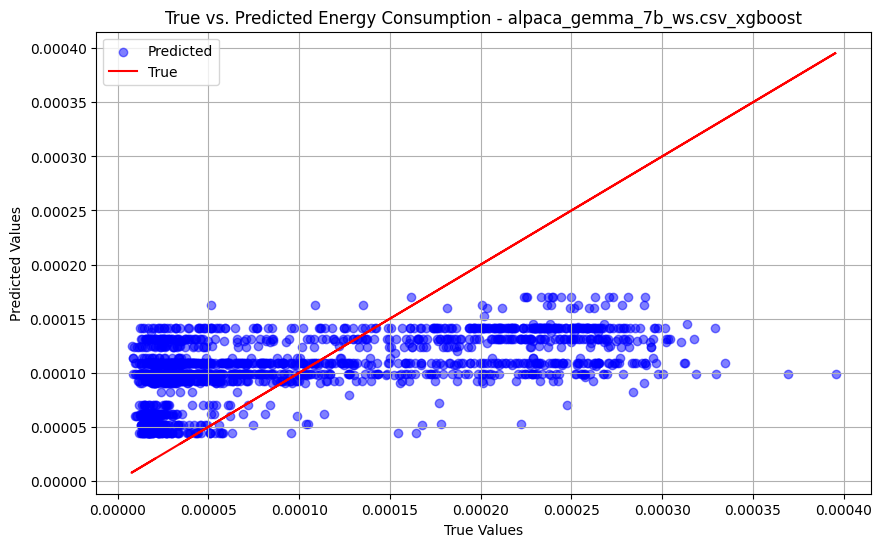

alpaca_gemma_2b_zbook.csv
../data/main_results/alpaca_gemma_2b_zbook.csv


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: random_forest
MSE: 9.075204632563053e-10
MAE: 1.897456538191936e-05
R^2: 0.41345898898248346


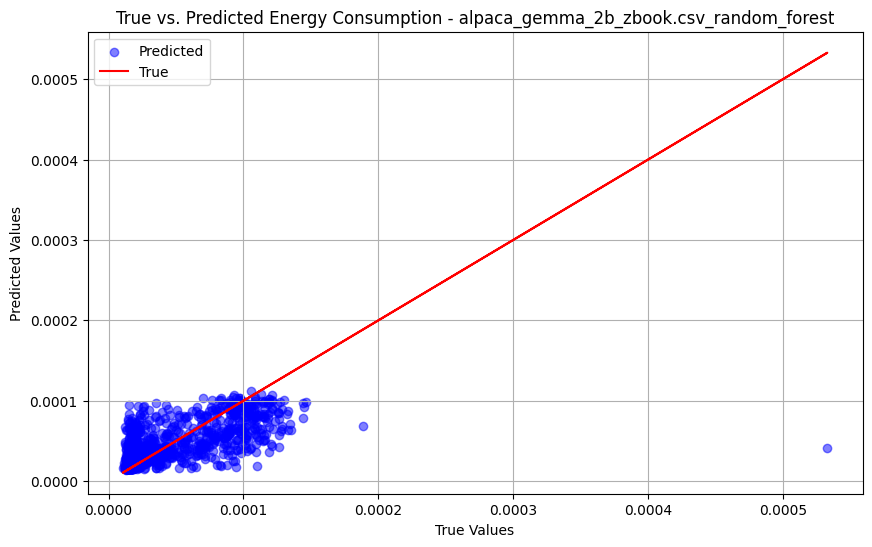

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: decision_tree
MSE: 1.5697616819848908e-09
MAE: 2.4243863568685563e-05
R^2: -0.01455519879328504


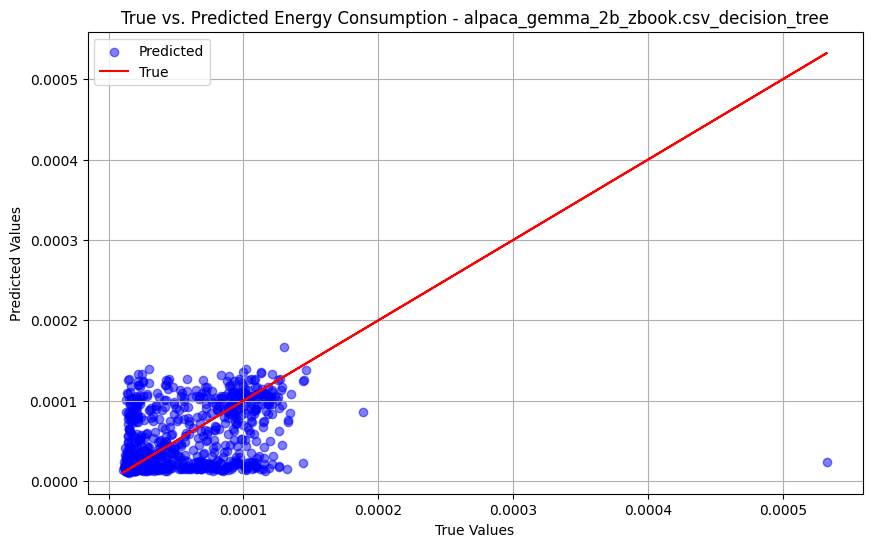

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: xgboost
MSE: 1.5476315954620645e-09
MAE: 3.208652282018683e-05
R^2: -0.00025226696028934903


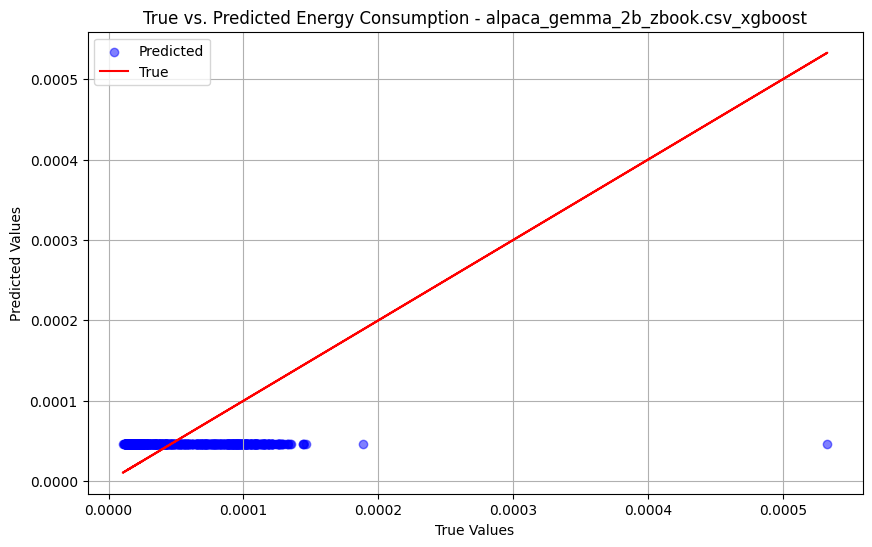

codefeedback_codellama_7b_cpu.csv
../data/main_results/codefeedback_codellama_7b_cpu.csv


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: random_forest
MSE: 6.752804506046465e-08
MAE: 7.965593273754337e-05
R^2: -2.474137211606614


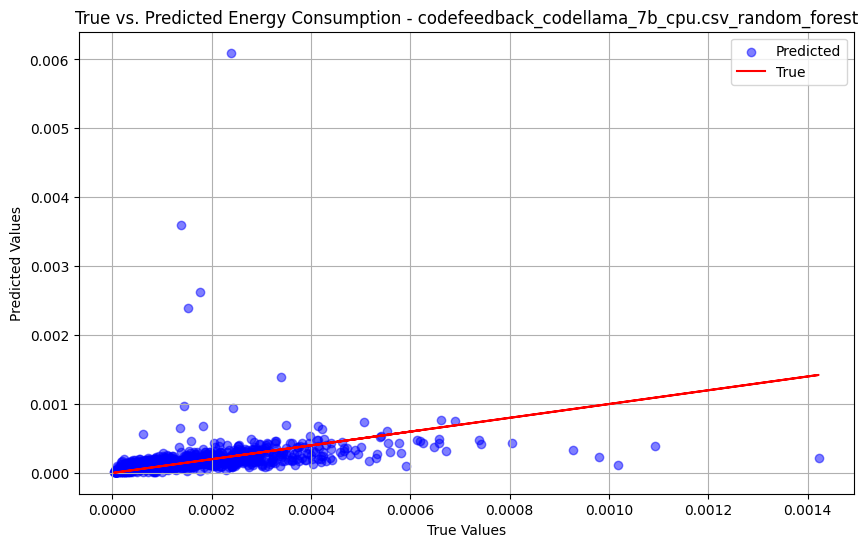

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: decision_tree
MSE: 2.824462202120121e-08
MAE: 8.799480391546488e-05
R^2: -0.45311021966883414


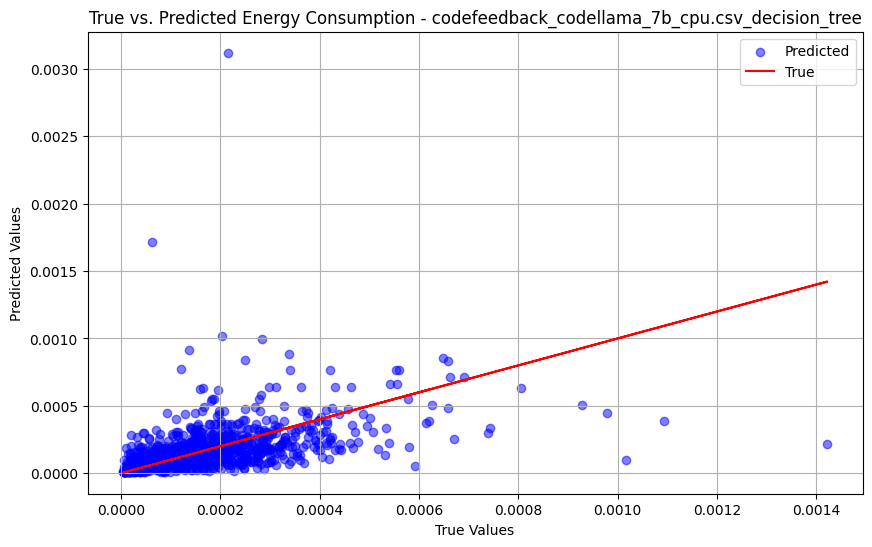

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: xgboost
MSE: 5.694833590708952e-07
MAE: 9.858986278451483e-05
R^2: -28.298394872343934


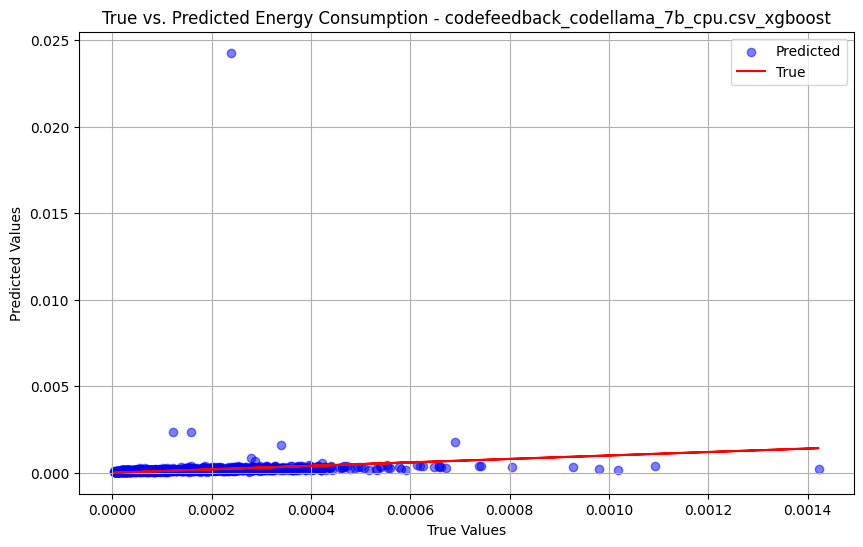

codefeedback_codellama_7b_ws.csv
../data/main_results/codefeedback_codellama_7b_ws.csv


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: random_forest
MSE: 9.773259072348578e-08
MAE: 0.00010573725832532186
R^2: -0.9802190853462542


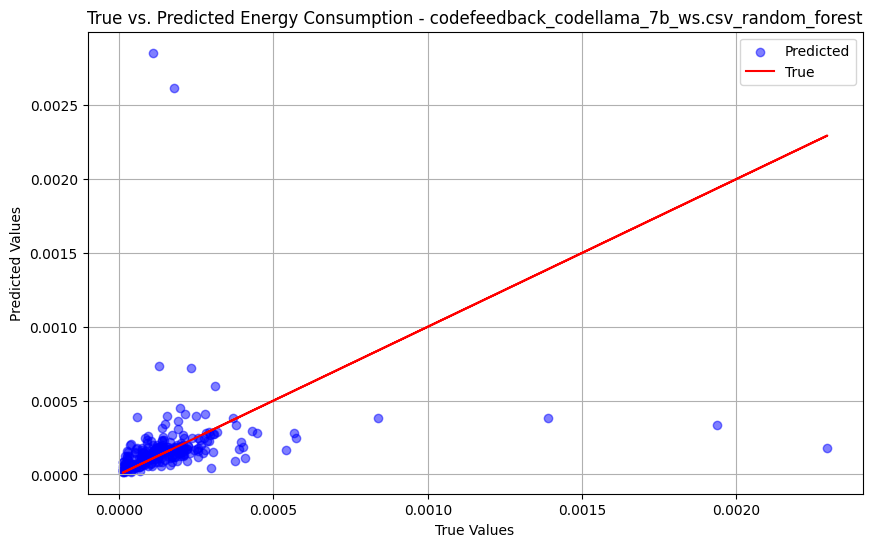

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: decision_tree
MSE: 4.7962444227112064e-08
MAE: 9.988452546510914e-05
R^2: 0.028203931408121385


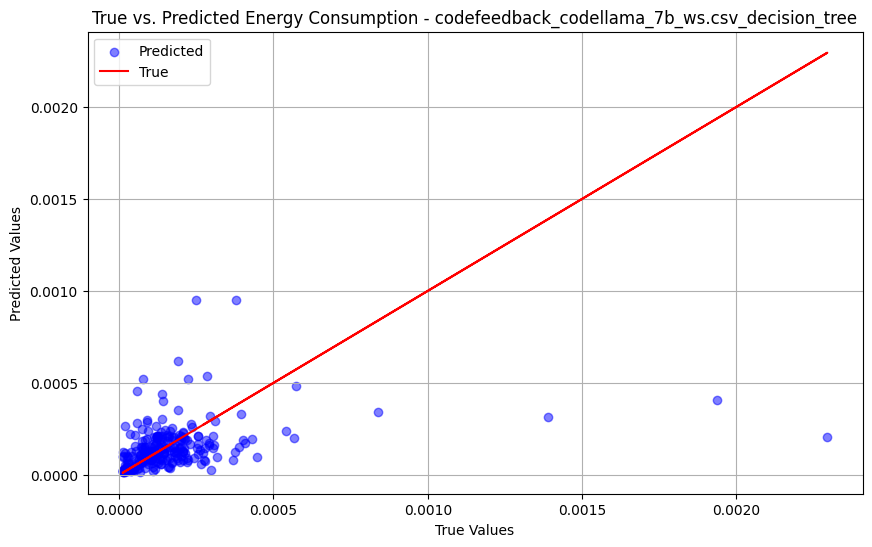

Model: xgboost
MSE: 4.4359686831577866e-08
MAE: 8.79688078283947e-05
R^2: 0.1012015763257117


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


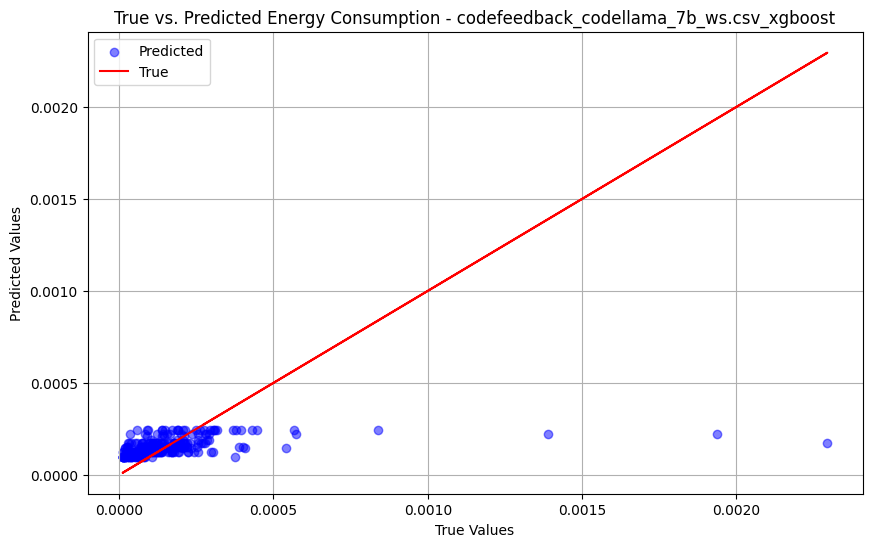

codefeedback_codellama_7b_zbook.csv
../data/main_results/codefeedback_codellama_7b_zbook.csv


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: random_forest
MSE: 5.547674032442609e-06
MAE: 0.0002053859711944675
R^2: -233.56530497546265


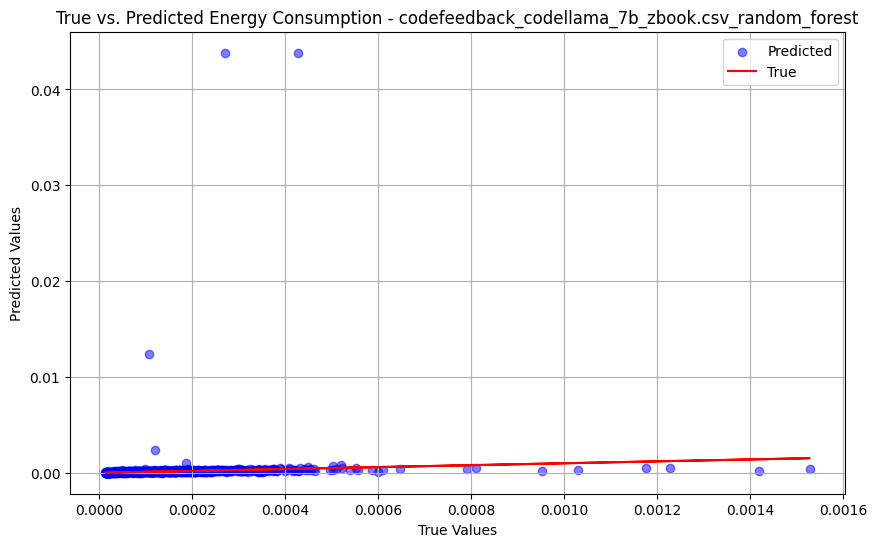

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: decision_tree
MSE: 4.496802025472786e-08
MAE: 9.093239459418924e-05
R^2: -0.9013260915311612


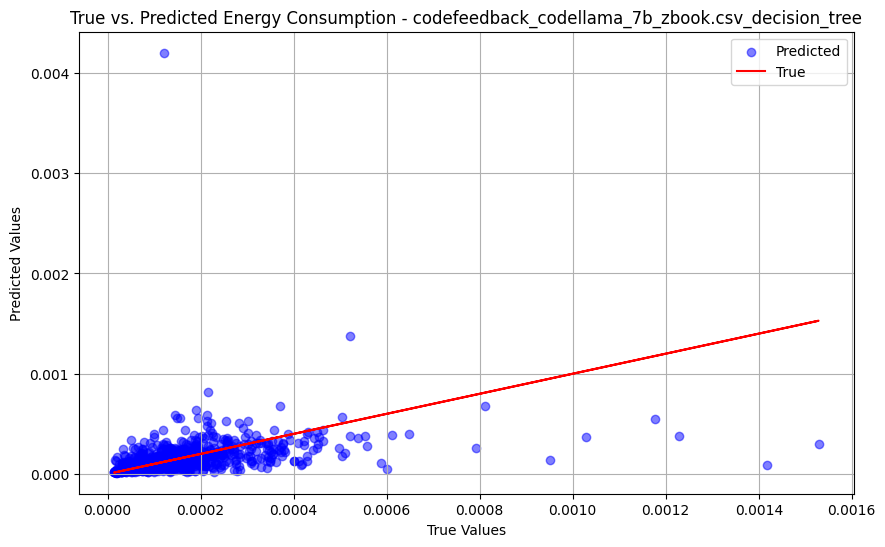

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: xgboost
MSE: 2.632917774241408e-08
MAE: 7.764147078310014e-05
R^2: -0.11324341891502665


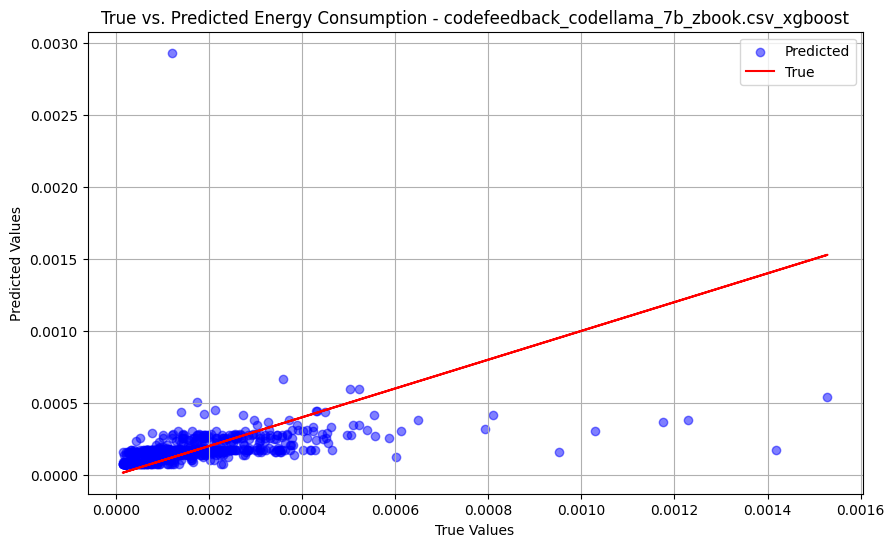

codefeedback_gemma_2b_zbook.csv
../data/main_results/codefeedback_gemma_2b_zbook.csv


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: random_forest
MSE: 6.942161339784827e-10
MAE: 1.9253091545905578e-05
R^2: 0.5205765527191522


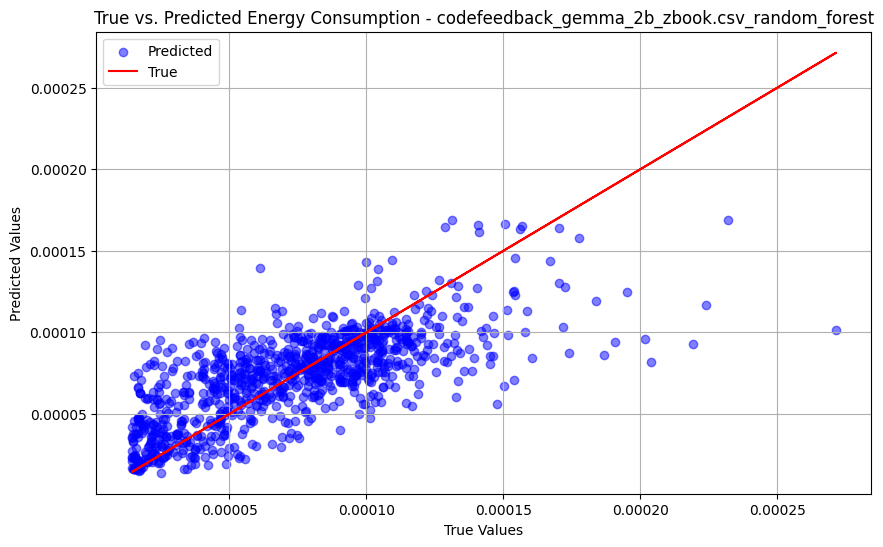

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: decision_tree
MSE: 1.2962758300458598e-09
MAE: 2.537045084494483e-05
R^2: 0.10479604744148618


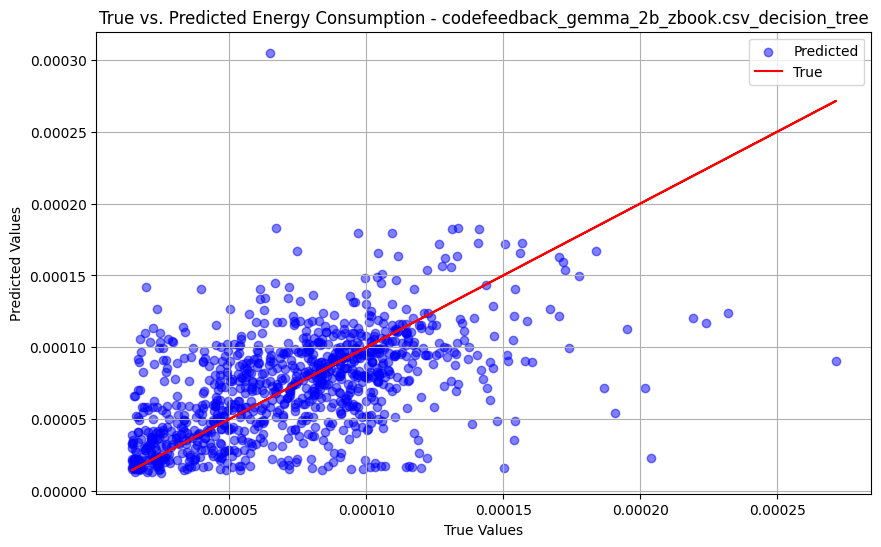

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: xgboost
MSE: 1.28794416348198e-09
MAE: 2.8739209914560178e-05
R^2: 0.11054986978894221


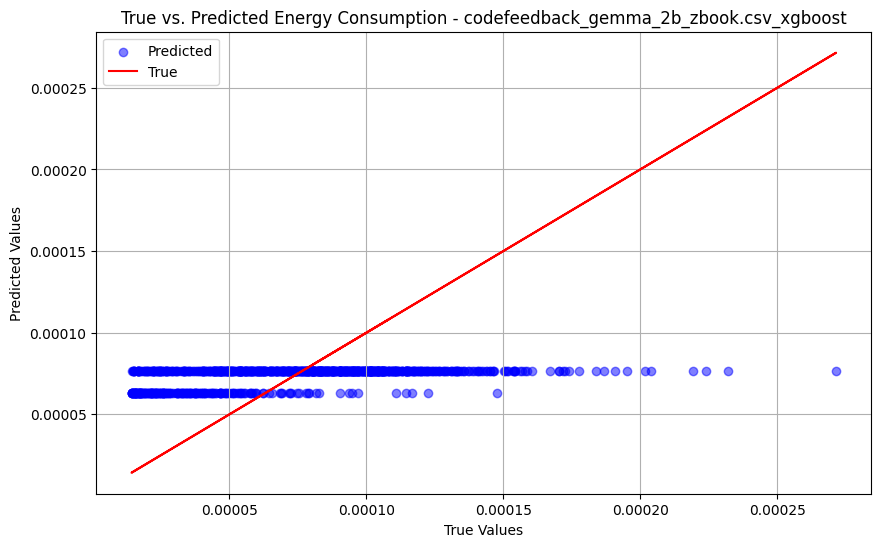

codefeedback_gemma_7b_zbook.csv
../data/main_results/codefeedback_gemma_7b_zbook.csv


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: random_forest
MSE: 3.537884451855586e-09
MAE: 4.254223325455582e-05
R^2: 0.5477432083590487


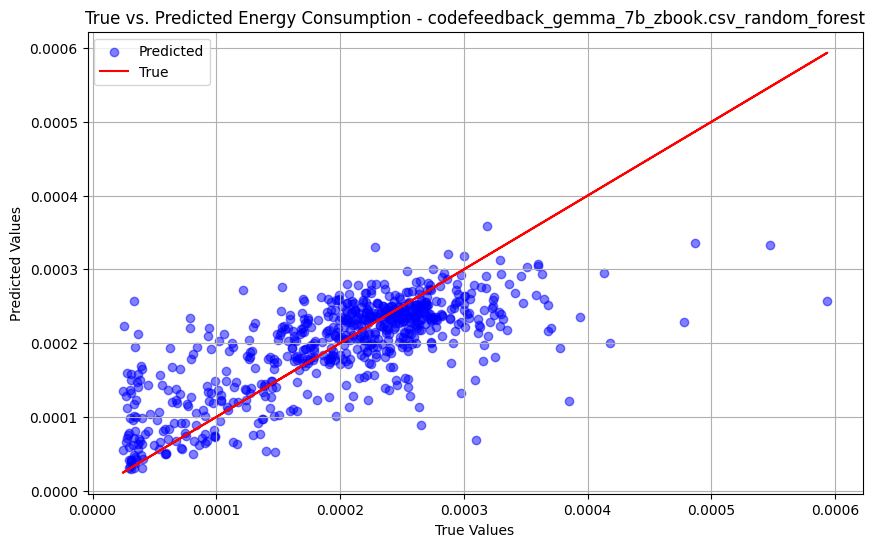

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: decision_tree
MSE: 6.26289154070416e-09
MAE: 5.5668879811085324e-05
R^2: 0.19939860299605505


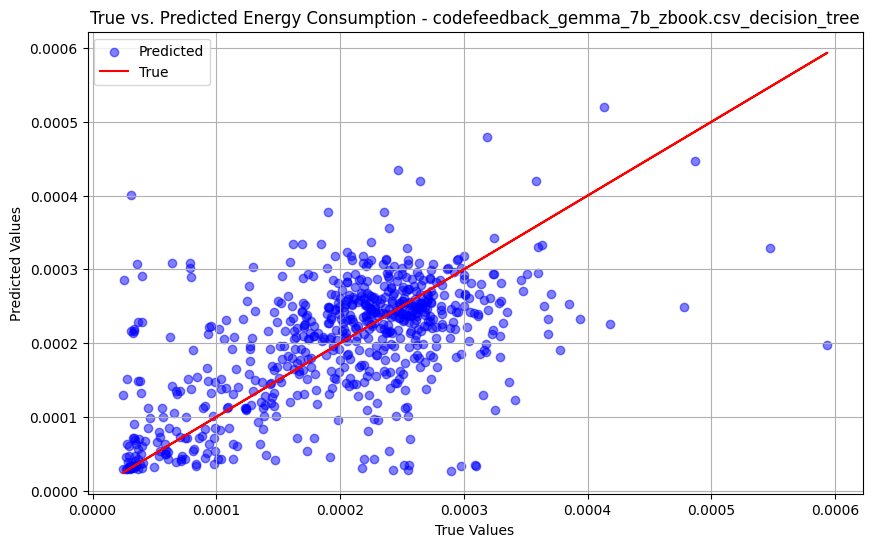

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: xgboost
MSE: 4.909702937664553e-09
MAE: 5.273966575336585e-05
R^2: 0.37238015296578664


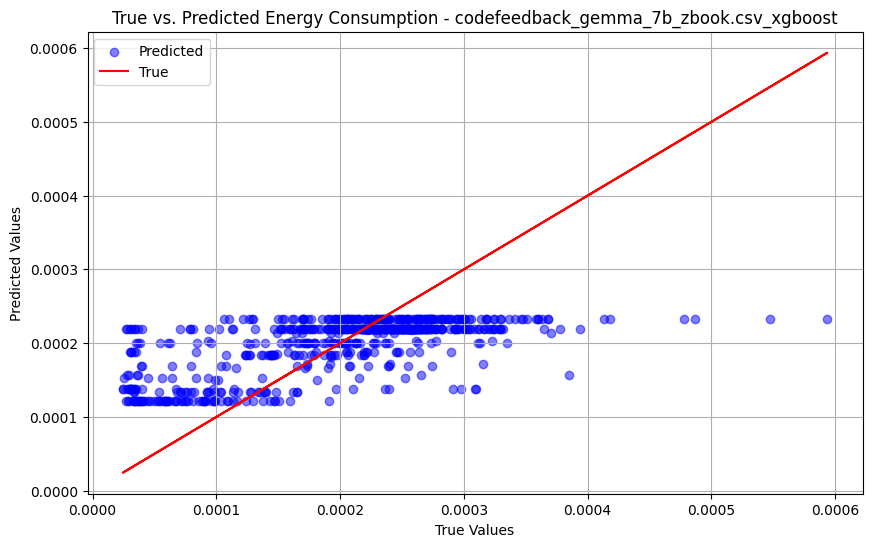

alpaca_gemma_2b_ws.csv
../data/main_results/alpaca_gemma_2b_ws.csv


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: random_forest
MSE: 4.4266492620865906e-10
MAE: 1.5004007352687607e-05
R^2: 0.529832949805058


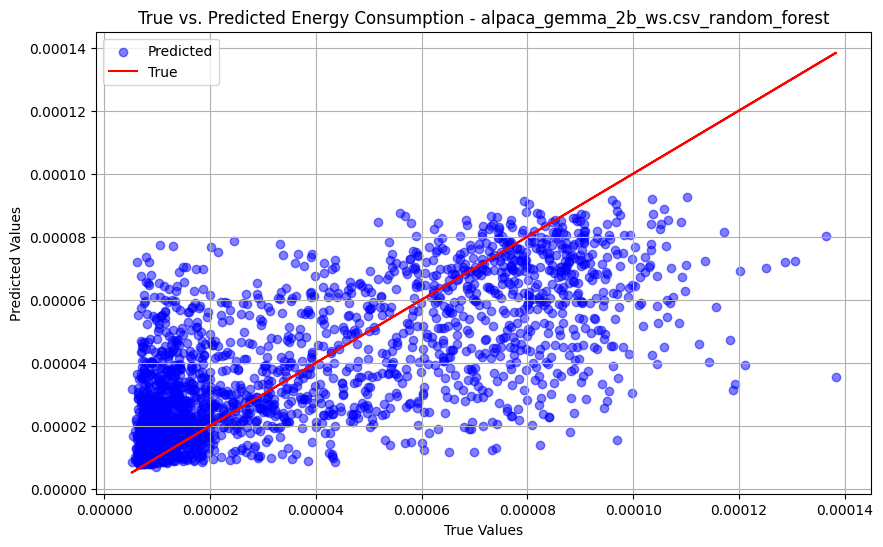

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: decision_tree
MSE: 8.783313243717754e-10
MAE: 1.9548209941206983e-05
R^2: 0.06709923596016687


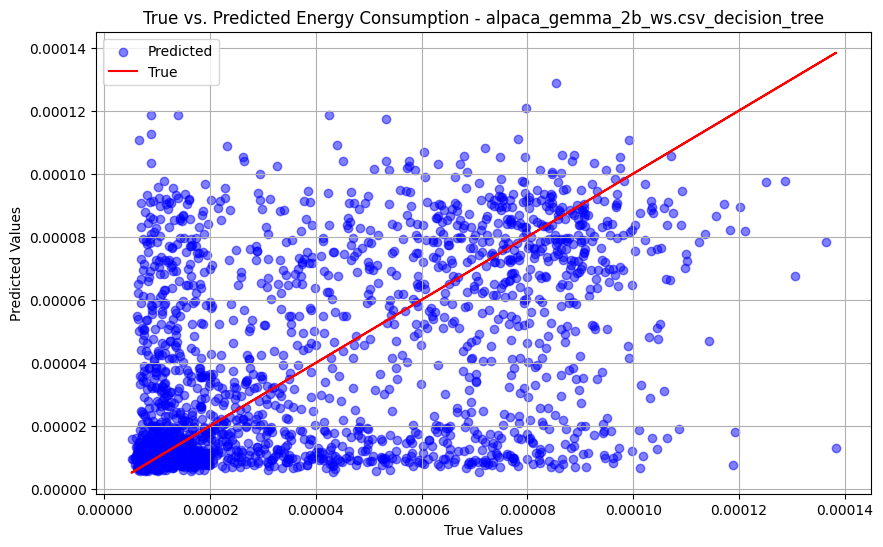

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: xgboost
MSE: 9.428727150608708e-10
MAE: 2.7112611004698097e-05
R^2: -0.0014520168704390546


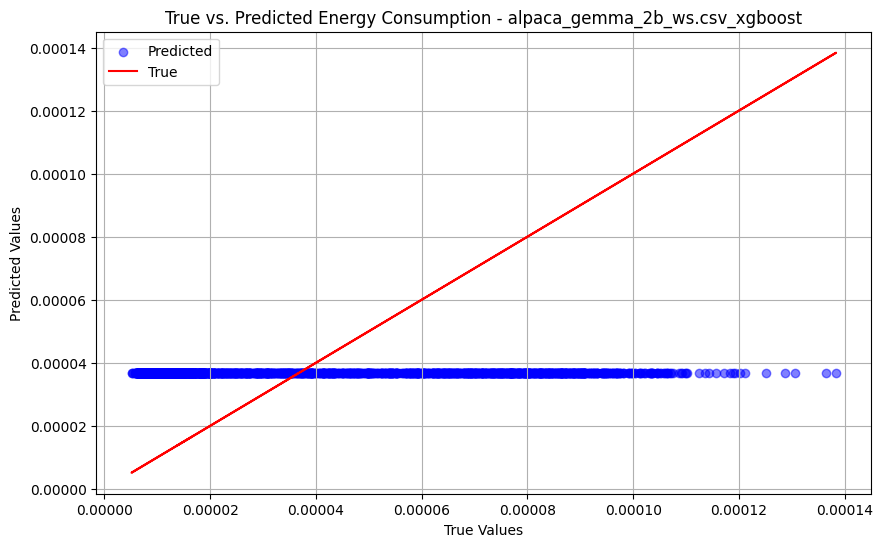

alpaca_gemma_2b_cpu.csv
../data/main_results/alpaca_gemma_2b_cpu.csv


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: random_forest
MSE: 3.771569436002639e-08
MAE: 7.611340286018431e-05
R^2: -0.9403715466725784


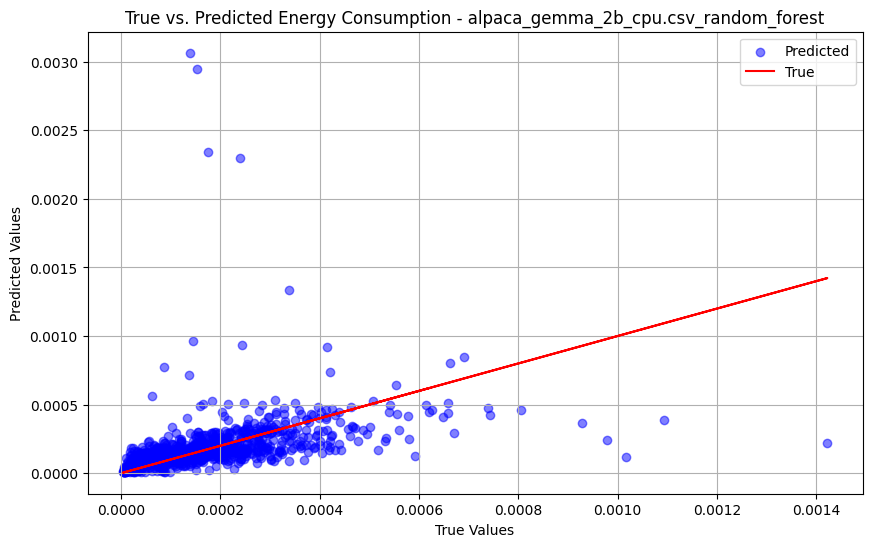

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: decision_tree
MSE: 1.0338299674926081e-07
MAE: 9.859113350864016e-05
R^2: -4.318778527238786


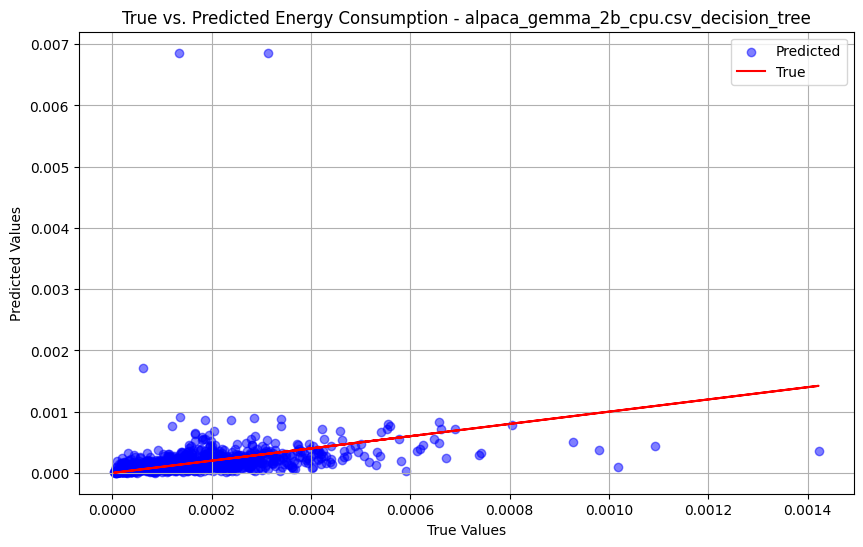

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: xgboost
MSE: 5.694833590708952e-07
MAE: 9.858986278451483e-05
R^2: -28.298394872343934


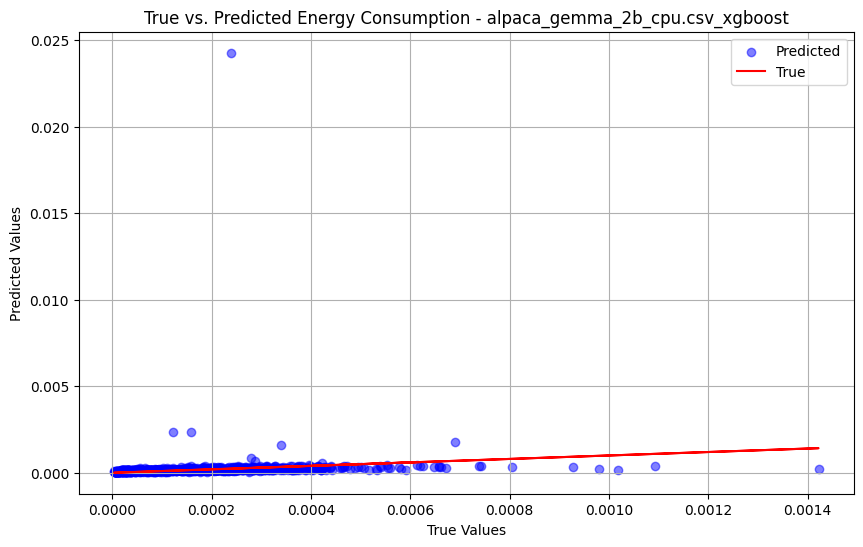

codefeedback_gemma_7b_ws.csv
../data/main_results/codefeedback_gemma_7b_ws.csv


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: random_forest
MSE: 2.328917925060366e-09
MAE: 3.549441356395859e-05
R^2: 0.5879065776855645


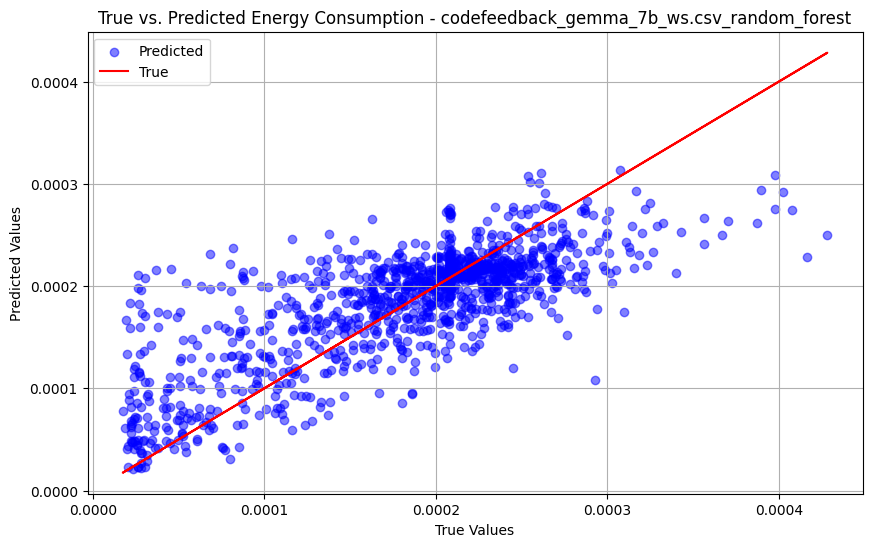

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: decision_tree
MSE: 4.74621346025113e-09
MAE: 4.890288977788128e-05
R^2: 0.1601750637824514


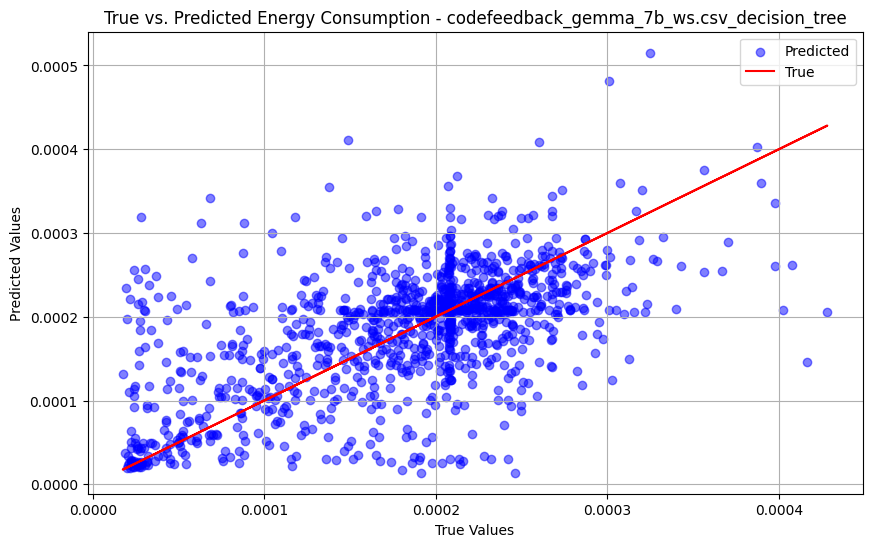

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: xgboost
MSE: 3.5376207439634e-09
MAE: 4.484202629867423e-05
R^2: 0.3740310796085139


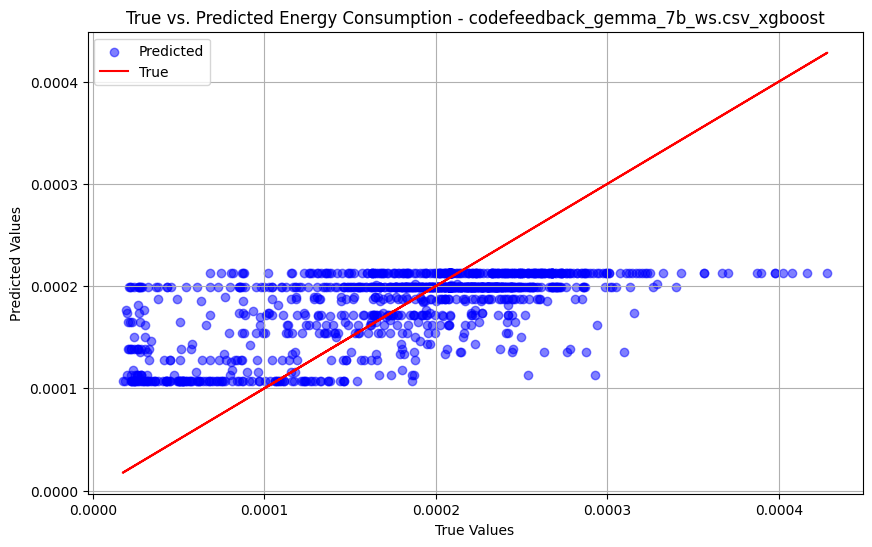

codefeedback_codellama_70b_ws.csv
../data/main_results/codefeedback_codellama_70b_ws.csv


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: random_forest
MSE: 1.5656885513921477e-05
MAE: 0.0028826706296150467
R^2: 0.04332007971369989


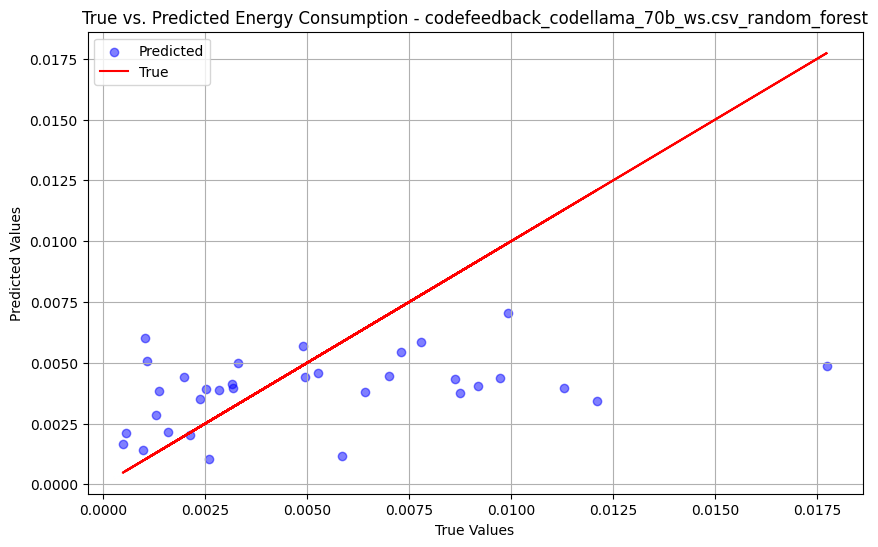

Model: decision_tree
MSE: 2.0190609256115862e-05
MAE: 0.0033192612740661816
R^2: -0.23370324426896927


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


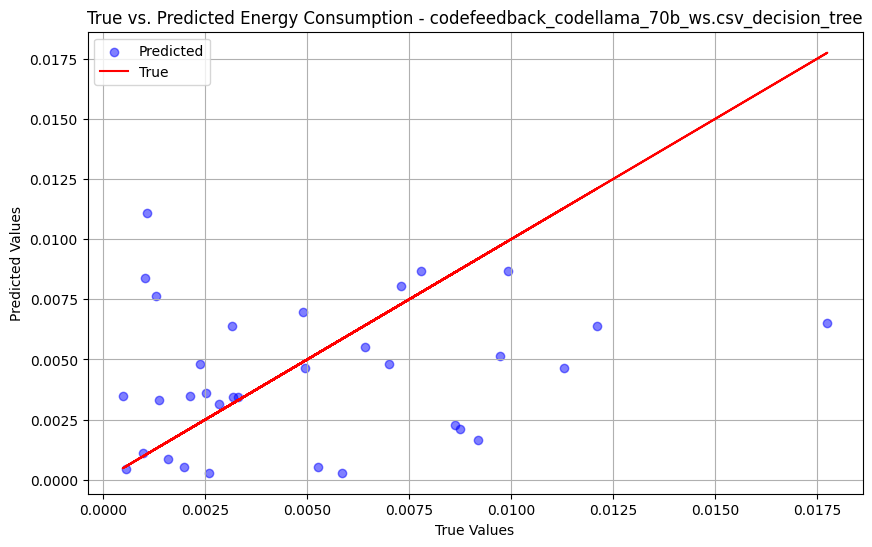

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: xgboost
MSE: 1.612833345170607e-05
MAE: 0.0029540923001680095
R^2: 0.014513279335817031


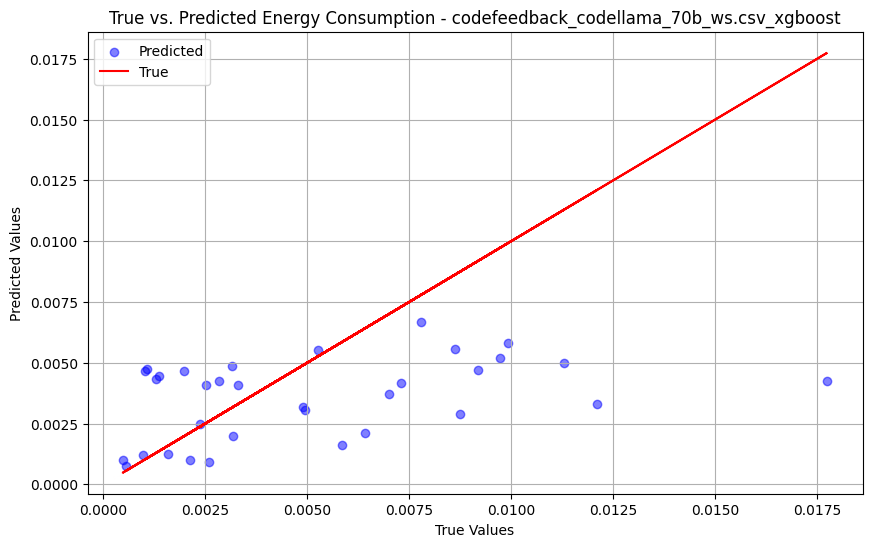

alpaca_llama3_8b_zbook.csv
../data/main_results/alpaca_llama3_8b_zbook.csv


/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: random_forest
MSE: 5.006527950673262e-09
MAE: 5.236892447942551e-05
R^2: 0.5062317499571087


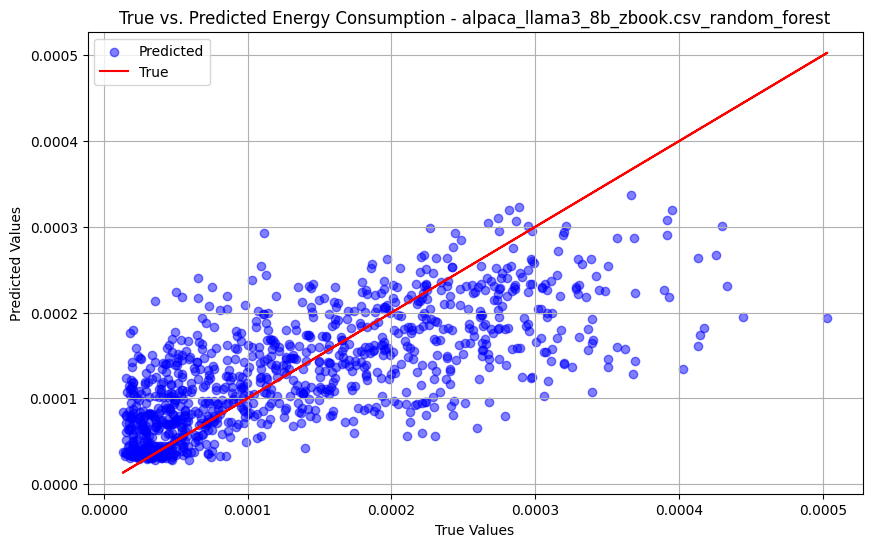

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: decision_tree
MSE: 1.009068070511522e-08
MAE: 7.109694117194216e-05
R^2: 0.004807762466144672


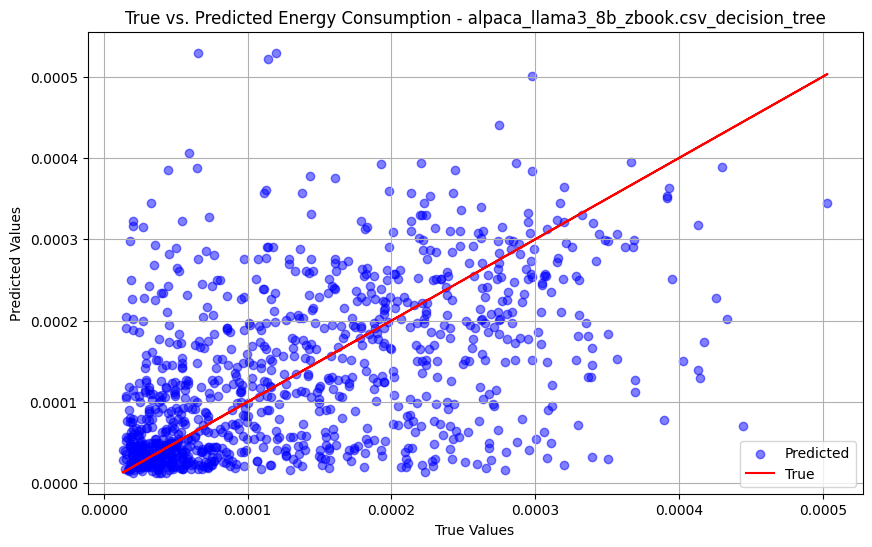

/Users/smu/Documents/Tool/e4llm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: xgboost
MSE: 7.538076665312476e-09
MAE: 7.055883142288236e-05
R^2: 0.2565580457370733


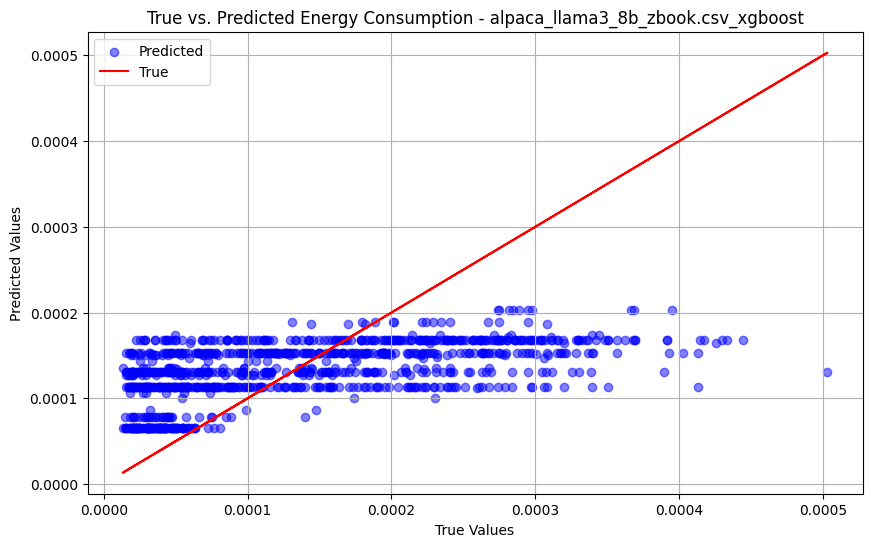

In [10]:
import os 
directory = "./data/main_results"
for filename in os.listdir(directory):
    if not filename.startswith("."):
        print(filename)
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            print(f)

            df = pd.read_csv(f)  # Replace with your dataset path
            df = df.dropna(axis=0) # drop rows with nan
            # df = pd.read_csv(config.MAIN_DATASET_PATH)  # Replace with your dataset path
            X_train, X_test, y_train, y_test = preprocess_data(df, "energy_consumption_llm", scale_features=True)

            # Easily switch between models by changing the model name
            # model_names = ["random_forest", "decision_tree", "gradient_boosting", "xgboost", "svm", "linear_regression"]#, "neural_network"]
            model_names = ["random_forest",  "decision_tree", "xgboost" ]#, "neural_network"]
            # model_names = ["linear_regression"]
            for model_name in model_names:
                train_and_evaluate(filename, model_name, X_train, X_test, y_train, y_test)

alpaca_llama3_70b_server.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-04 17:42:53.877465: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 17:42:53.896882: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and set

alpaca_llama3_70b_server & 2.2527691702352312e-06 & 0.001116348487968811 & 0.359846569533272


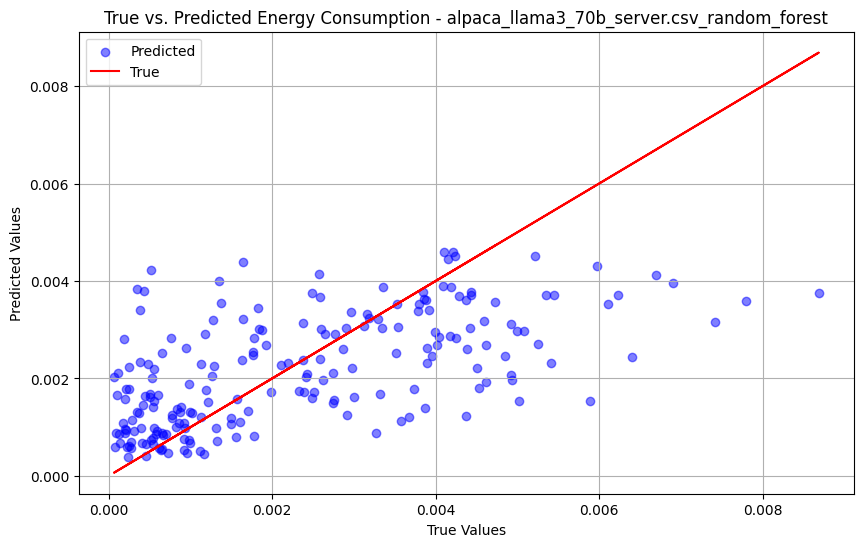

codefeedback_codellama_7b_workstation.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_codellama_7b_workstation & 8.688501184889379e-08 & 9.554628884649735e-05 & -0.7604297340331307


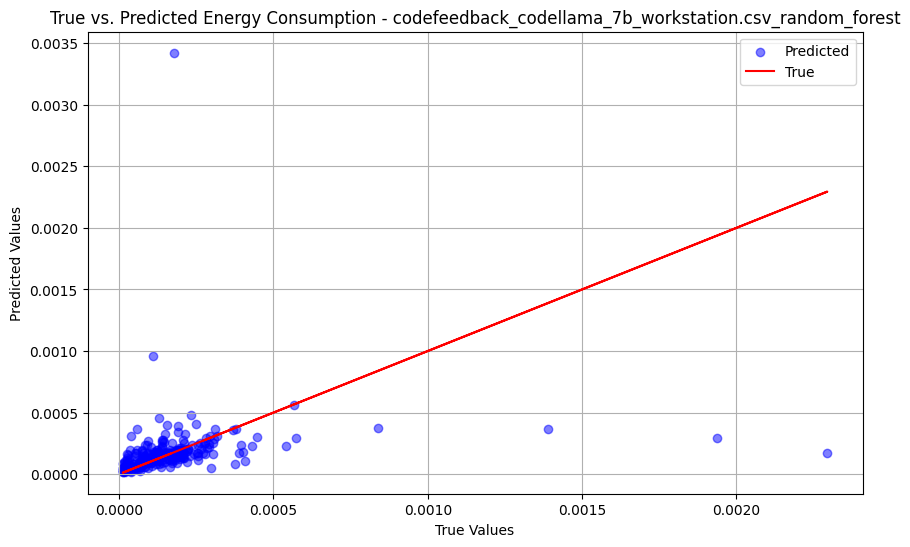

alpaca_gemma_2b_laptop1.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_gemma_2b_laptop1 & 5.7805271866850624e-08 & 7.765902071439387e-05 & -1.973926549181828


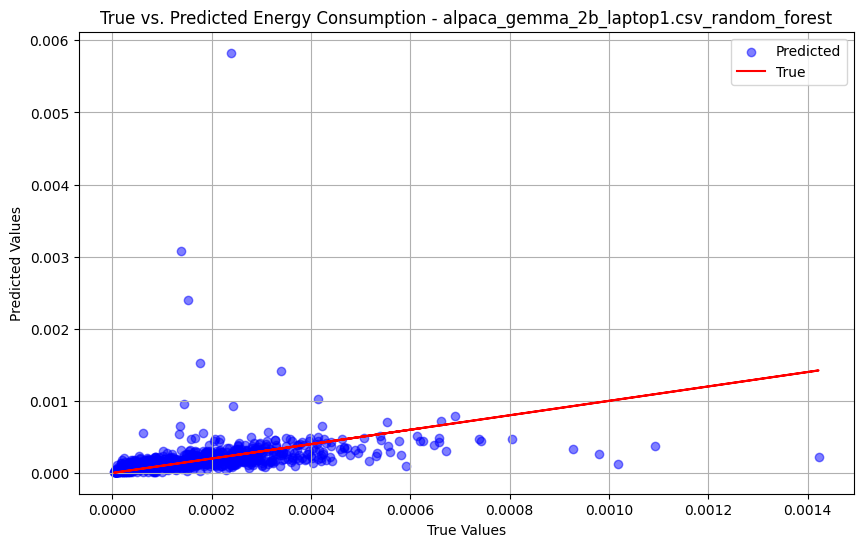

alpaca_gemma_2b_workstation.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_gemma_2b_workstation & 4.480954008749963e-10 & 1.5060389591246824e-05 & 0.5240650876956786


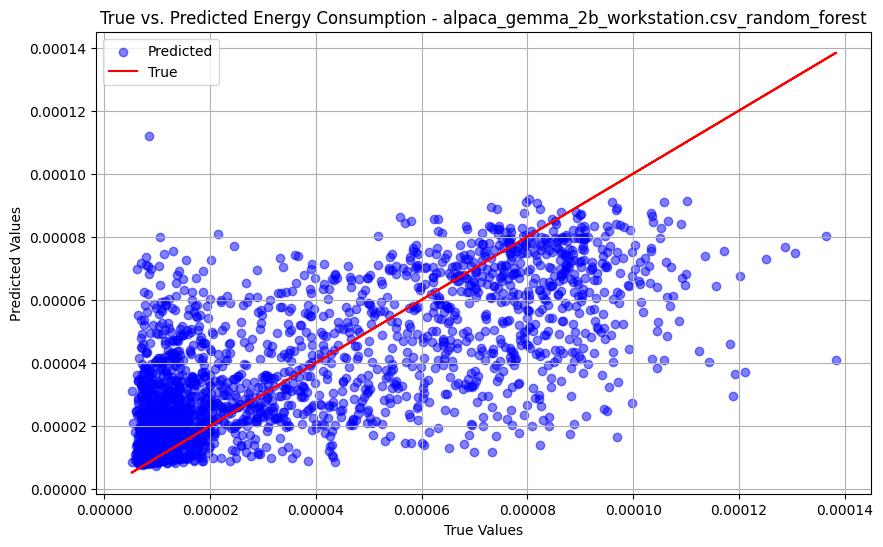

alpaca_gemma_7b_laptop2.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_gemma_7b_laptop2 & 3.868290237634876e-09 & 4.476440334804298e-05 & 0.4604927875640178


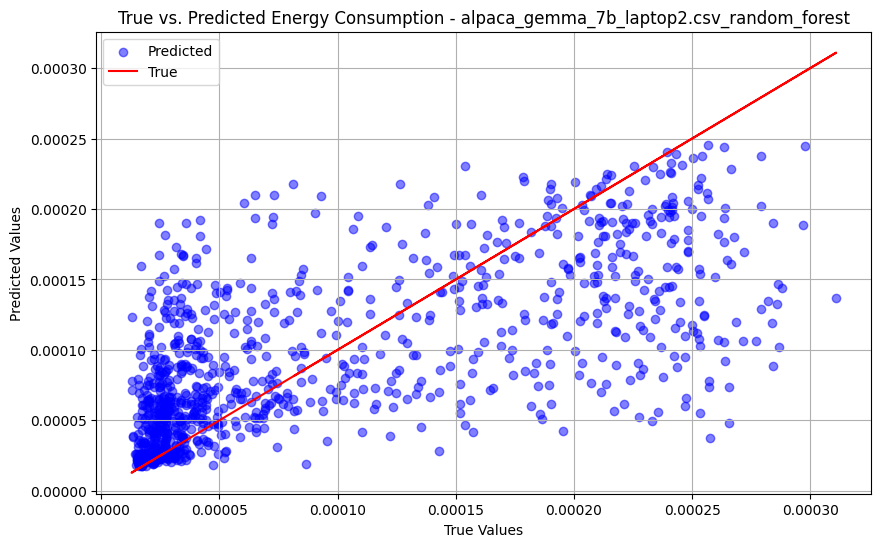

codefeedback_gemma_2b_laptop2.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_gemma_2b_laptop2 & 7.115985060453757e-10 & 1.9420672013985356e-05 & 0.5085723420269148


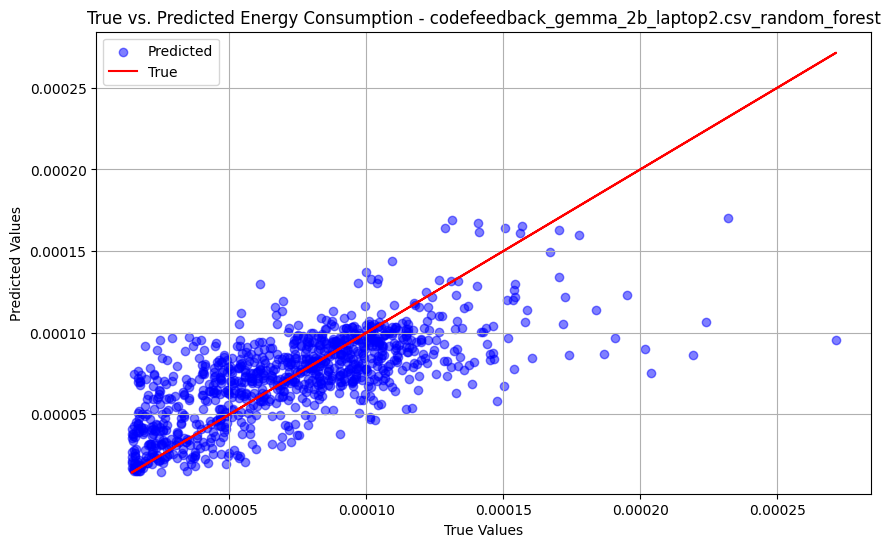

codefeedback_codellama_7b_laptop1.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_codellama_7b_laptop1 & 5.495273584244575e-08 & 7.754380092005108e-05 & -1.8271712041846517


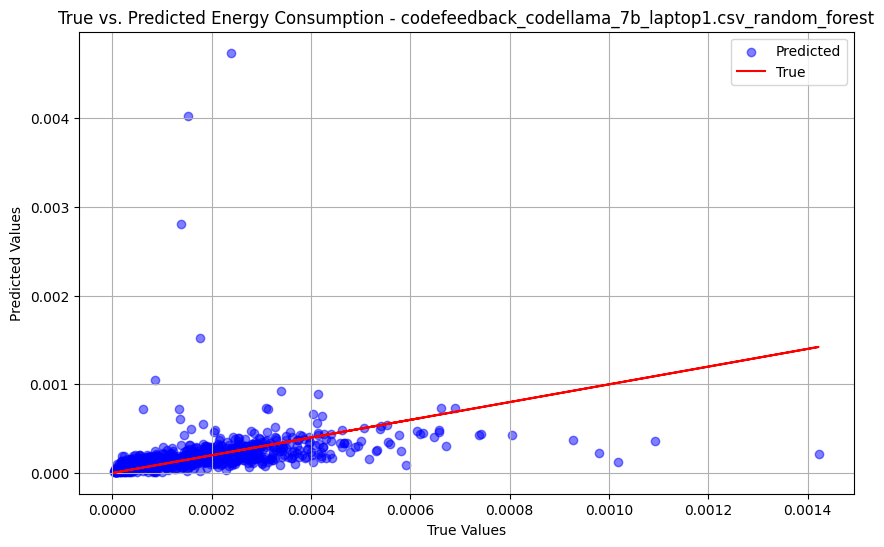

codefeedback_codellama_7b_laptop2.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_codellama_7b_laptop2 & 2.7890708822188828e-06 & 0.00018371409998832518 & -116.92676683237028


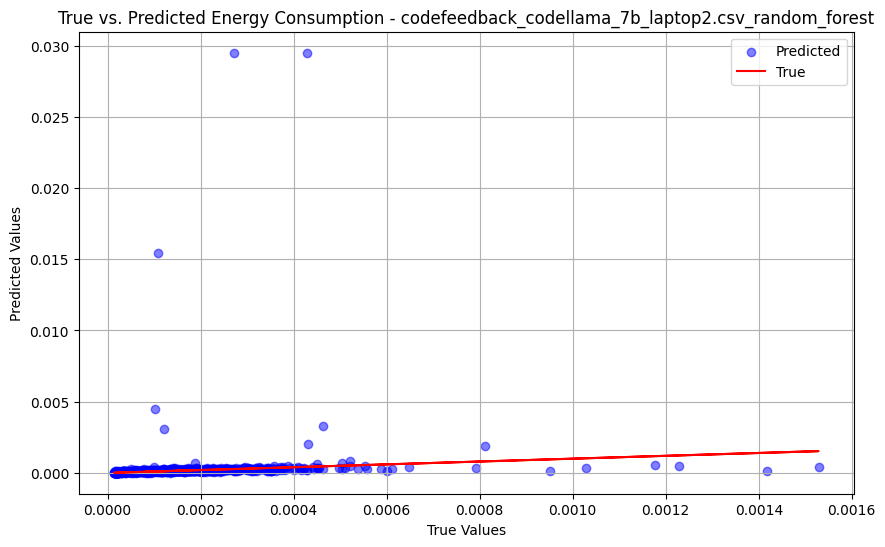

alpaca_llama3_8b_laptop2.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_llama3_8b_laptop2 & 4.990208737447472e-09 & 5.237049877556777e-05 & 0.5078412305064965


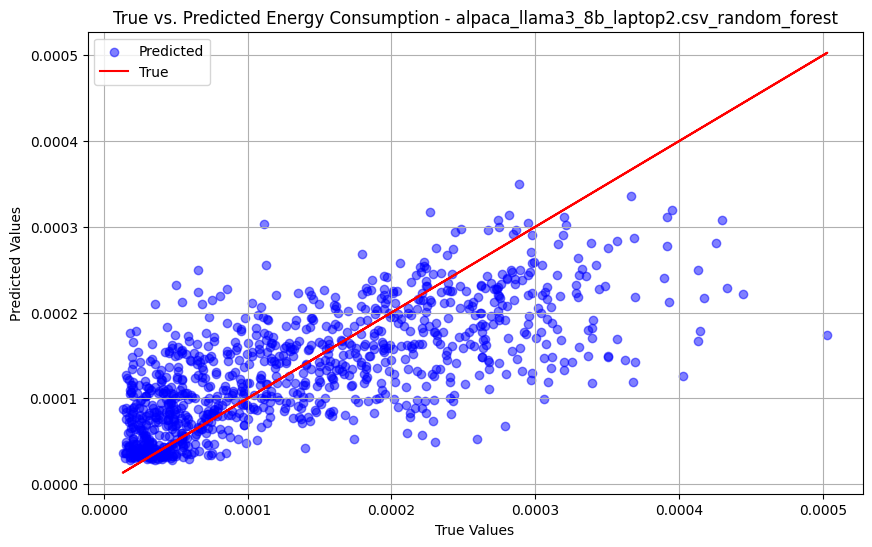

codefeedback_gemma_7b_workstation.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_gemma_7b_workstation & 2.3323500313345385e-09 & 3.538835696084105e-05 & 0.5872992791607639


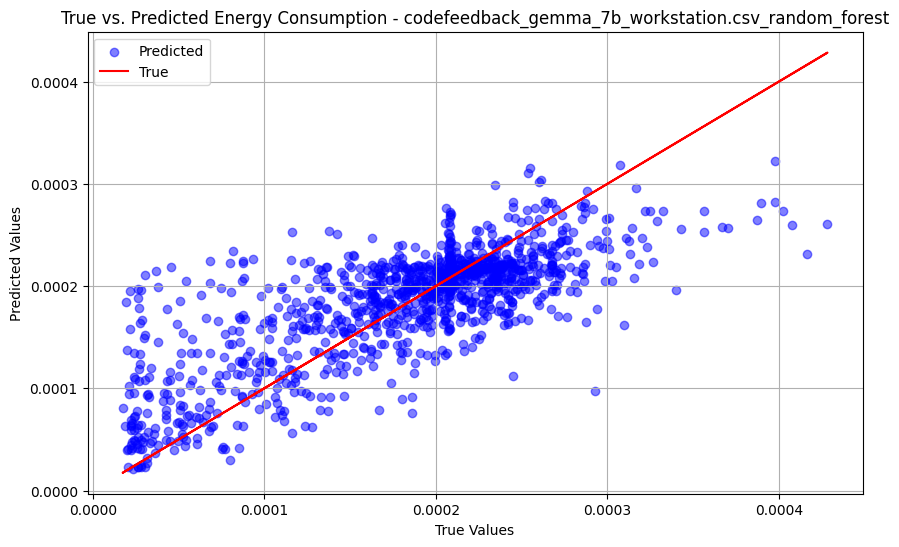

alpaca_gemma_7b_workstation.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_gemma_7b_workstation & 4.07322700733847e-09 & 4.653308000800161e-05 & 0.5065525411407898


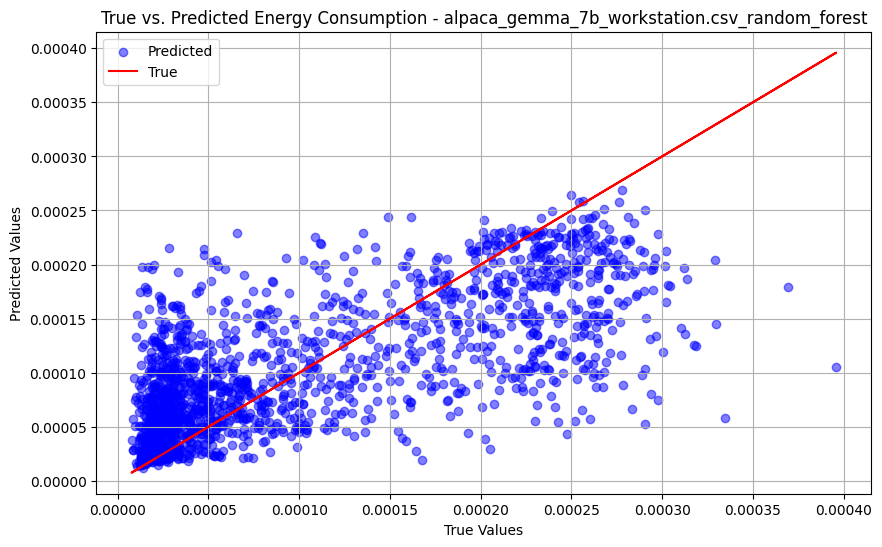

codefeedback_gemma_7b_laptop2.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_gemma_7b_laptop2 & 3.505015321120398e-09 & 4.2249951983296774e-05 & 0.5519449531623664


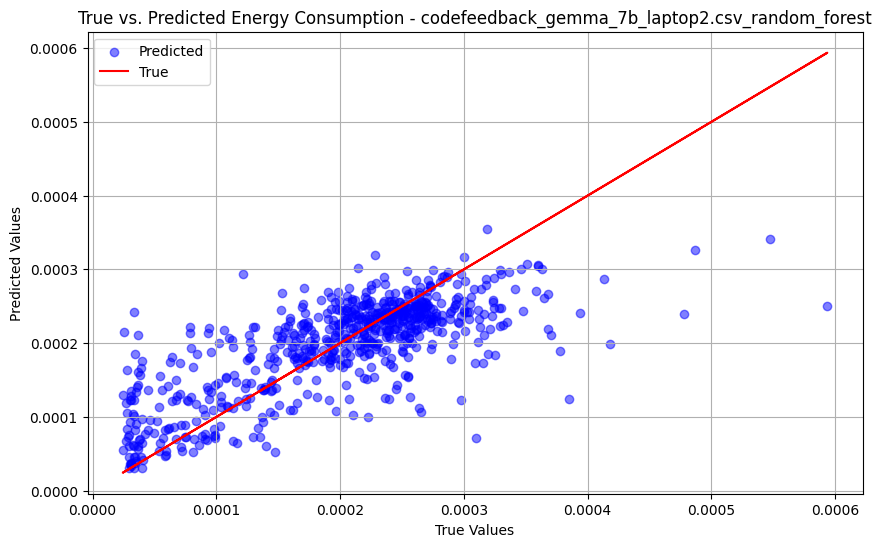

codefeedback_codellama_70b_workstation.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_codellama_70b_workstation & 1.599418893848301e-05 & 0.002858536651189722 & 0.022709887920772887


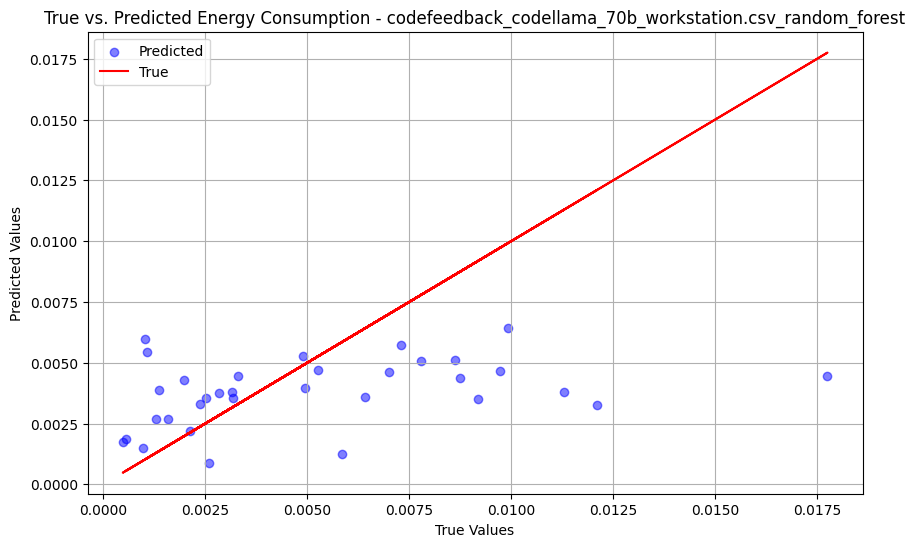

alpaca_gemma_2b_laptop2.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_gemma_2b_laptop2 & 8.928139333185039e-10 & 1.8786096219182737e-05 & 0.4229639900127923


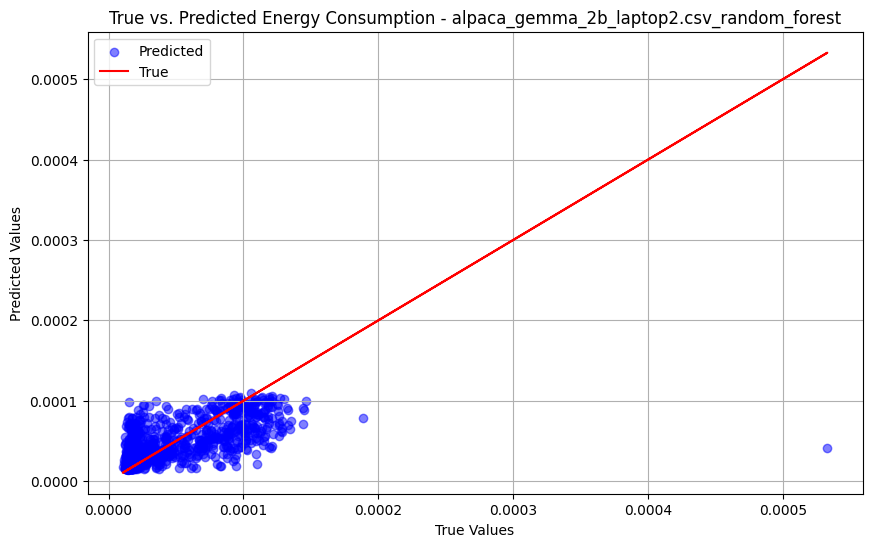

NameError: name 'data' is not defined

In [3]:
import os 
directory = "../data/main_results"

results = {}

for filename in os.listdir(directory):
    if not filename.startswith("."):
        print(filename)
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            # print(f)

            df = pd.read_csv(f)  # Replace with your dataset path
            df = df.dropna(axis=0) # drop rows with nan
            # df = pd.read_csv(config.MAIN_DATASET_PATH)  # Replace with your dataset path
            X_train, X_test, y_train, y_test = preprocess_data(df, "energy_consumption_llm", scale_features=True)

            # Easily switch between models by changing the model name
            # model_names = ["random_forest", "decision_tree", "gradient_boosting", "xgboost", "svm", "linear_regression"]#, "neural_network"]
            model_names = ["random_forest"]#, "neural_network"]
            # model_names = ["linear_regression"]
            for model_name in model_names:
                model, mse, mae, r2 = train_and_evaluate(filename, model_name, X_train, X_test, y_train, y_test)
                results[filename] = r2
                
df = pd.DataFrame(resul)
df.to_csv("r2_results.csv", index=False)

In [11]:
results
df = pd.DataFrame(list(results.items()), columns=["dataset", "R2"])
df.to_csv("r2_results.csv")